In [132]:
from brian2 import *
%matplotlib inline


STDP Fuction

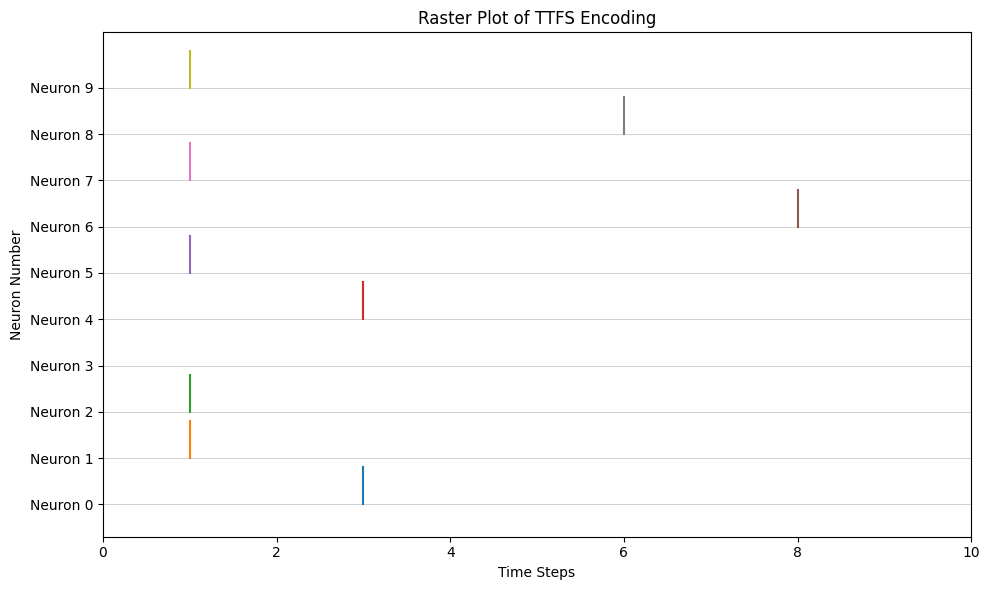

Original data: [0.25684012 0.97946116 0.6782191  0.09038411 0.27156874 0.88090403
 0.12219998 0.75232409 0.16030721 0.50046719]
Spike times: [3. 1. 1. 0. 3. 1. 8. 1. 6. 1.]


In [267]:
import numpy as np

def ttfs_encode(data, threshold=1.0):

  spike_times = np.zeros_like(data)
  for i, value in enumerate(data):

    membrane_potential = 0.0
    for t in range(len(data)):
      membrane_potential += value

      if membrane_potential >= threshold:
        spike_times[i] = t
        break
  return spike_times

# Example usage
data = np.random.rand(10)  
spike_times = ttfs_encode(data)

data = np.random.rand(10)  
spike_times = ttfs_encode(data)

# Generate raster plot
num_neurons = len(data)
time_steps = len(data)

plt.figure(figsize=(10, 6))
for i in range(num_neurons):
  spike_time = spike_times[i]
  plt.plot([0, time_steps], [i, i ], color='gray', alpha=0.5, lw=0.5)
  if spike_time > 0:
    plt.plot([spike_time, spike_time], [i, i + 0.8])
plt.xlabel("Time Steps")
plt.ylabel("Neuron Number")
plt.title("Raster Plot of TTFS Encoding")
plt.xlim(0, time_steps)
plt.ylim(-0.7, num_neurons +0.2)
plt.yticks(range(num_neurons), [f"Neuron {i}" for i in range(num_neurons)])
plt.tight_layout()
plt.show()

print("Original data:", data)
print("Spike times:", spike_times)



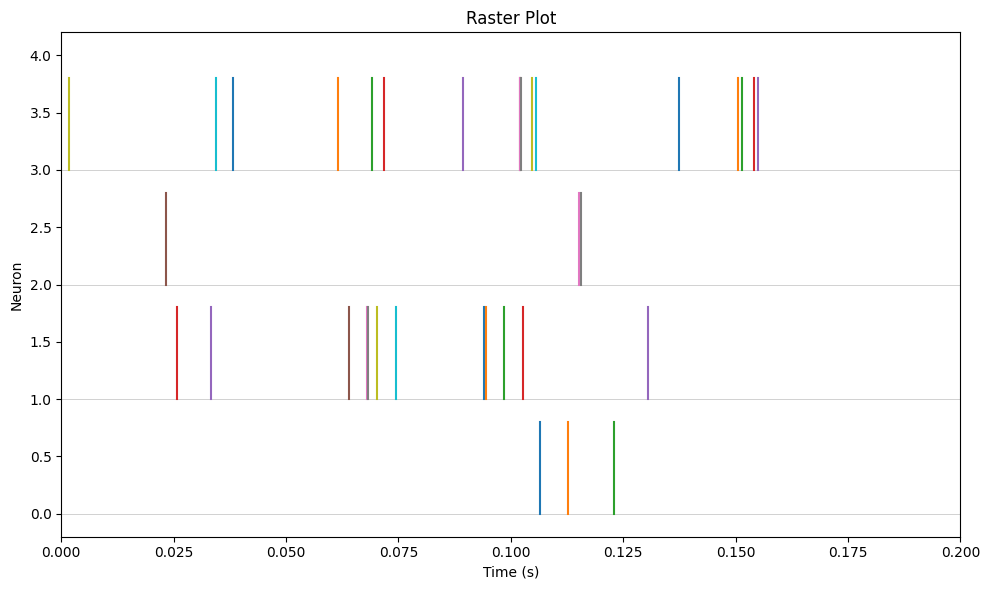

In [237]:
import numpy as np


def poisson_spiking(rate, time):

  lambda_t = rate * time

  spike_count = np.random.poisson(lambda_t)

  interspike_intervals = np.random.exponential(1 / rate, size=spike_count)
  spike_times = np.cumsum(interspike_intervals)

  spike_times = spike_times[spike_times <= time]

  return spike_times


def rate_encode_input(input_data, time, rate_min=10, rate_max=100):

  normalized_data = (input_data - np.min(input_data)) / (np.max(input_data) - np.min(input_data))

  firing_rates = rate_min + (rate_max - rate_min) * normalized_data

  spike_trains = []
  for rate in firing_rates:
    spike_trains.append(poisson_spiking(rate, time))

  return spike_trains

def plot_raster(spike_trains, time, title="Raster Plot"):

  num_neurons = len(spike_trains)
  max_spikes = max(len(train) for train in spike_trains)

  plt.figure(figsize=(10, 6))
  plt.xlim(0, time)
  plt.ylim(-0.2, num_neurons + 0.2)
  plt.xlabel("Time (s)")
  plt.ylabel("Neuron")
  plt.title(title)

  for i, spike_train in enumerate(spike_trains):
    plt.plot([0, time_steps], [i, i ], color='gray', alpha=0.5, lw=0.5)
    for spike_time in spike_train:
      plt.plot([spike_time, spike_time], [i , i + 0.8])

  plt.tight_layout()
  plt.show()

# Example usage
input_data = np.array([0.2, 0.7, 0.4, 0.9])
simulation_time = 0.2  # second

spike_trains = rate_encode_input(input_data, simulation_time)


plot_raster(spike_trains, simulation_time)


In [238]:
import brian2 as brn
import numpy as np


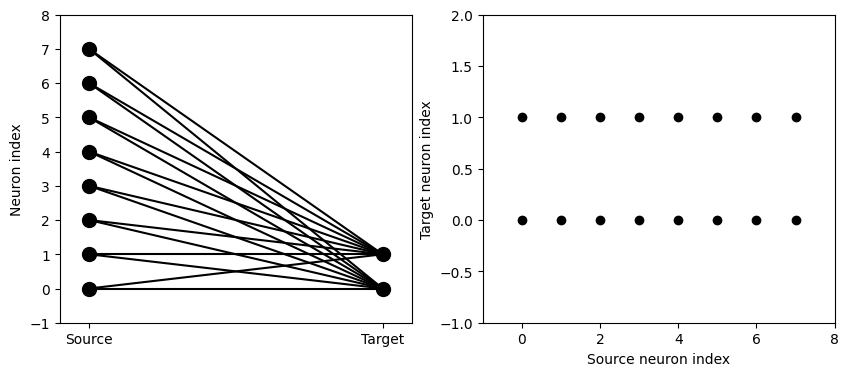

In [274]:
import brian2 as br
start_scope()

br.defaultclock.dt = 0.1*ms  # milliseconds
tau = 10*ms  
El = -70*mV  
Ek = -80*mV  
Vr = -60*mV  

# Input layer neurons
eqs_in = """
dv/dt = (El - v + (I/g)) / tau : volt
I : amp
"""
in_neurons = br.NeuronGroup(8, eqs_in, threshold='v > Vr', reset='v = Vr')

# Output layer neurons
eqs_out = """
dv/dt = (El - v + (I/g)) / tau : volt
I : amp
"""
out_neurons = br.NeuronGroup(2, eqs_out, threshold='v > Vr', reset='v = Vr')

# Synapses between input and output layers (fully connected)
syn = br.Synapses(in_neurons, out_neurons, 
                  model='w:volt', pre='v += dpre')

# Initial weight values (you can adjust these)
syn.connect(True) 
syn.w = 0.1*volt  

visualise_connectivity(syn)


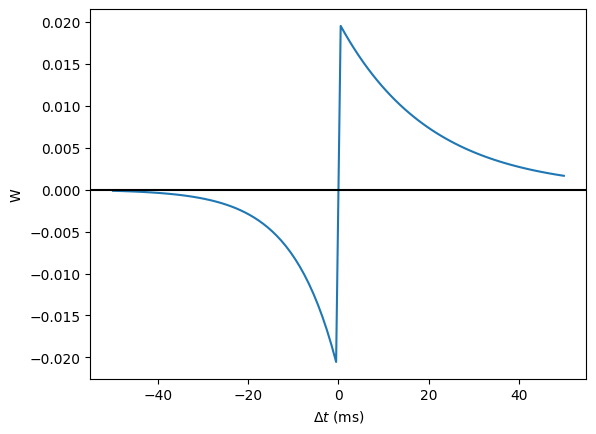

In [373]:
tau_pre = 20*ms
tau_post = 10*ms
A_pre = 0.02
A_post = -A_pre*1.08
delta_t = linspace(-50, 50, 100)*ms
W = where(delta_t>0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
plt.plot(delta_t/ms, W)
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('W')
plt.axhline(0, ls='-', c='k');

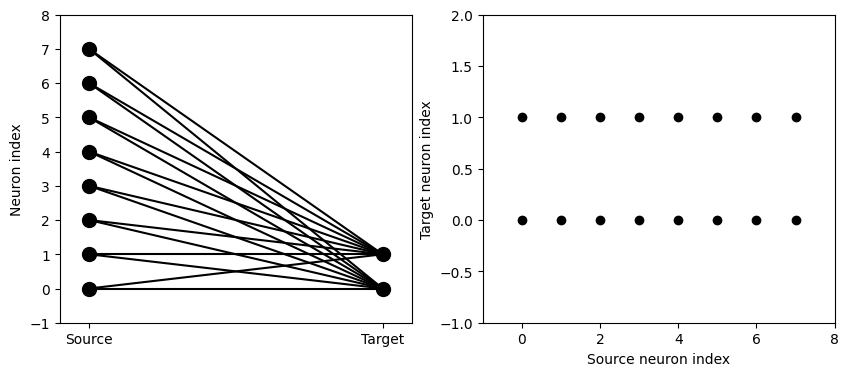

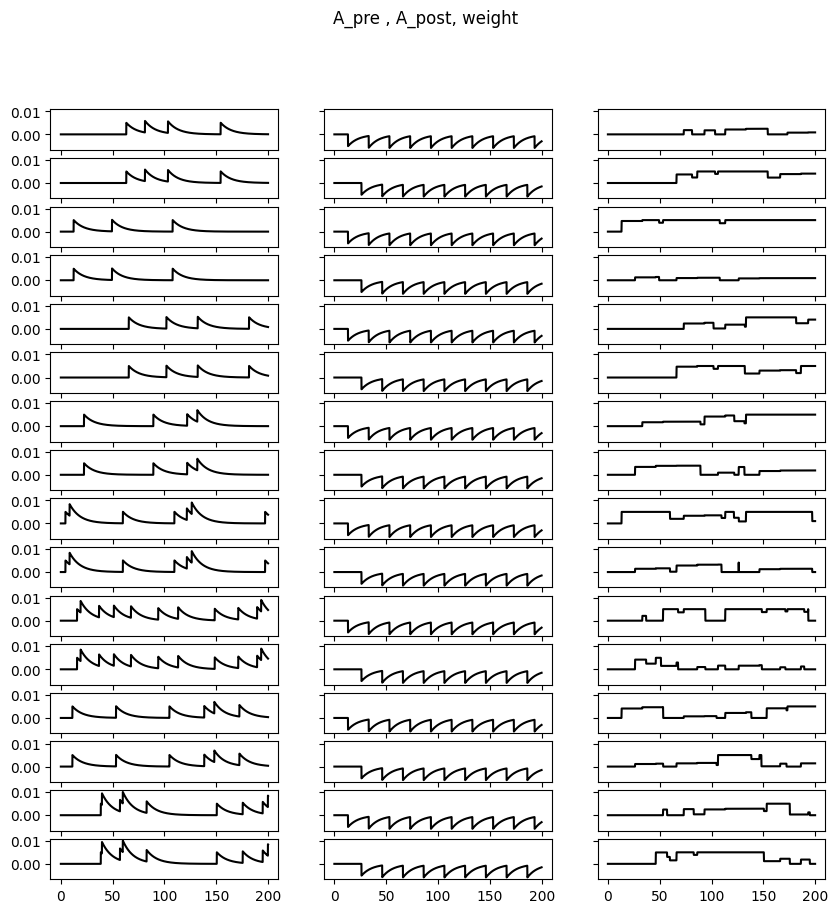

In [459]:
start_scope()

taupre = 10*ms
taupost = 10*ms
wmax = 0.005
Apre = 0.005
Apost = -Apre*taupre/taupost*1.02
G1 =  PoissonGroup(8,np.arange(8)*Hz + 30*Hz)
G2 = NeuronGroup(2, 'v:1', threshold='t>(1+i)*13*ms', refractory=20*ms)

S = Synapses(G1, G2,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(True)
visualise_connectivity(S)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(200*ms)

fig, axs = plt.subplots(16,3,figsize=(10, 10),sharex=True, sharey=True)

fig.suptitle('A_pre , A_post, weight')
for i in range(16):
    axs[i][0].plot(M.t/ms, M.apre[i], label='A_pre'+ str(i), color = 'black')
    axs[i][1].plot(M.t/ms, M.apost[i], label='A_post'+str(i),color = 'black')    
    axs[i][2].plot(M.t/ms, M.w[i], label='w'+str(i), color = 'black')



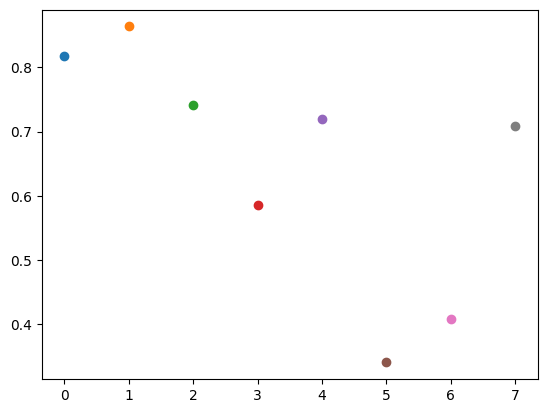

In [472]:
plt.figure()
for i in range(8):
    plt.scatter(i, np.dot(M.w[2*i],M.w[2*i+1])/(np.linalg.norm(M.w[2*i])*np.linalg.norm(M.w[2*i+1])))